In [ ]:
import numpy as np
import math
import json
import random
import glob



```json
{
    'label_name': 'A',
    'left': [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]
    ],
    'rigth': [
        [0, 0, 0],
        [32, -49, -17],
        [55, -99, -30],
        [57, -139, -42],
        [49, -176, -51],
        [23, -80, -44],
        [99, -68, -70],
        [87, -56, -82],
        [62, -59, -89],
        [11, -42, -48],
        [101, -33, -68],
        [82, -28, -66],
        [57, -30, -69],
        [10, -9, -53],
        [95, -5, -69],
        [76, -2, -59],
        [55, -4, -54],
        [13, 20, -60],
        [81, 19, -68],
        [67, 17, -62],
        [45, 14, -60]
    ],
    'absolute': [-3198, -2390, 0]
}
```



In [ ]:
def readJSON(dir):
    with open(dir) as f:
        data = json.load(f)
    return data

In [ ]:
def readFiles():
    res = {}

    for file in glob.glob(f"data/*.json"):
        label = file.split('/')[1].split('.')[0]
        print(f"label: '{label}', path: '{file}'")
        res[label] = readJSON(file)

    return res

In [ ]:
dict_labels = readFiles()

label: 'K', path: 'data/K.json'
label: 'F', path: 'data/F.json'
label: 'G', path: 'data/G.json'
label: 'E', path: 'data/E.json'
label: 'A', path: 'data/A.json'
label: 'H', path: 'data/H.json'
label: 'D', path: 'data/D.json'
label: 'I', path: 'data/I.json'
label: 'C', path: 'data/C.json'
label: 'B', path: 'data/B.json'


In [ ]:
labels_name = list(dict_labels.keys())

In [ ]:
def make(test_part=.25):
    data_hands = []
    label = []

    total_data = []

    for label_name in labels_name:
        total_data = total_data + dict_labels[label_name]

    total_data = random.sample(total_data, len(total_data))

    for data in total_data:
        rigth = np.array(data['rigth']).flatten()
        left = np.array(data['left']).flatten()
        absolute = np.array(data['absolute'])
        label_name = data['label_name']

        features = np.concatenate([rigth, left, absolute])
        data_hands.append(features)
        label.append(label_name)

    data_list = {
        "data": data_hands,
        "label": label
    }

    data_hands = np.array(data_hands)
    label = np.array(label)

    part = math.floor(test_part * len(data_hands))

    data_train = {
        "data": data_hands[part:],
        "label": label[part:]
    }

    data_test = {
        "data": data_hands[:part],
        "label": label[:part]
    }

    return data_train, data_test, data_list

In [ ]:
dataAll, labelAll, listAll = make(test_part=0.25)

In [ ]:
train_pairs, train_labels = dataAll["data"], dataAll["label"]
test_pairs, test_labels = labelAll["data"], labelAll["label"]

In [ ]:
print(train_pairs.shape)
print(train_labels.shape)
print(test_pairs.shape)
print(test_labels.shape)

(7500, 129)
(7500,)
(2500, 129)
(2500,)


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [ ]:
# uso de gpu por tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

num_classes = len(label_encoder.classes_)
train_labels_cat = to_categorical(train_labels_encoded, num_classes)
test_labels_cat = to_categorical(test_labels_encoded, num_classes)

In [ ]:
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_pairs, train_labels_cat))
train_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_pairs, test_labels_cat))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
model = build_model(input_shape=(129,), num_classes=num_classes)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30
)

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5578 - loss: 165.3273 - val_accuracy: 0.9980 - val_loss: 0.0080
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9168 - loss: 10.5301 - val_accuracy: 0.9988 - val_loss: 0.0034
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9607 - loss: 2.9796 - val_accuracy: 0.9996 - val_loss: 6.8034e-04
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9780 - loss: 1.1756 - val_accuracy: 0.9984 - val_loss: 0.0025
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9817 - loss: 0.6597 - val_accuracy: 1.0000 - val_loss: 1.1187e-04
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9864 - loss: 0.7332 - val_accuracy: 1.0000 - val_loss: 9.1836e-05
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9856 - loss: 0.4097 - val_accuracy: 1.0000 - val_loss: 1.9831e-04
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9862 - loss: 0.745

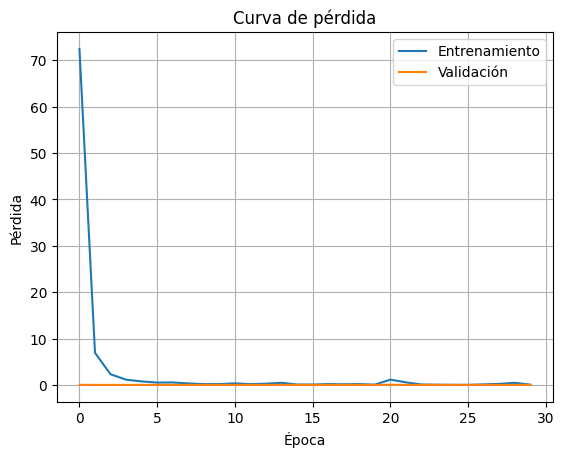

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curva de pérdida')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_pairs)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_labels_cat, axis=1)

print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

print("Matriz de confusión:")
print(confusion_matrix(y_true, y_pred))

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Reporte de clasificación:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       251
           B       1.00      1.00      1.00       245
           C       1.00      1.00      1.00       238
           D       1.00      1.00      1.00       245
           E       1.00      1.00      1.00       268
           F       1.00      1.00      1.00       285
           G       1.00      1.00      1.00       247
           H       1.00      1.00      1.00       239
           I       1.00      1.00      1.00       227
           K       1.00      1.00      1.00       255

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500

Matriz de confusión:
[[251   0   0   0   0   0   0   0   0   0]
 [  0 245   0   0   0   0   0   0   0   0]
 [  0   0 238   0   0   0   0   0   0   0]
 [  0   0   0 245   0   0

In [ ]:
model.save('modelo_clasificador_manos.h5')

In [ ]:
model = tf.keras.models.load_model('modelo_clasificador_manos.h5')

In [ ]:
def predict_random():
    index = random.randint(0, len(listAll["data"]) - 1)

    # 2. Extraer el dato y el label reales
    input_data = np.array([listAll["data"][index]])  # Asegúrate de que sea un batch (1, n)
    true_label = listAll["label"][index]

    # 3. Predecir con el modelo
    prediction = model.predict(input_data)
    predicted_index = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_index])[0]

    # 4. Mostrar resultados
    print(f"Índice de muestra: {index}")
    print(f"Etiqueta real     : {true_label}")
    print(f"Etiqueta predicha : {predicted_label}")

In [ ]:
predict_random()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Índice de muestra: 8002
Etiqueta real     : I
Etiqueta predicha : I


In [ ]:
import pickle

# Guardar el LabelEncoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)